# **Object Detection for Upload into Physics Generator (Unity)**

Let's import all **necessary libraries**

In [ ]:
import os
import json
import glob
import numpy as np
import torch
import torchvision
import cv2
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt
from torchvision import transforms as T

Explore different torchvision models ... `https://pytorch.org/vision/stable/models.html`

In [ ]:
# get pretrained model for OBJ_DET and instance segmentation ...
model0 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model1 = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# Inference
model0.eval()
model1.eval()
model0.name = "fasterrcnn_resnet50_fpn"
model1.name = "maskrcnn_resnet50_fpn"   # not sure if we need mask r-cnn

models = []
models.append(model0)
models.append(model1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 90.0MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `Non

Define labels for our data, detect them, and display bounded boxes

In [ ]:
# Defing PyTorch Transform
transform = T.Compose([T.ToTensor()])

# Define class names from MS-COCO dataset

# added "table"
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'plate', 'jar'
]

In [ ]:
def get_detection(img, model, threshold=0.5):
    pred = model([img]) # Pass the image to model

    # pred is a list and each element of list is dict with keys: "labels", "scores", and "boxes"
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Classes
    pred_boxes = pred[0]['boxes']  # Get Prediction Boxes
    pred_score = pred[0]['scores']  # Get Prediction Scores

    try:
        pred_t = torch.nonzero(pred_score > threshold, as_tuple=False)[-1] # Get (last) list of index with score greater than threshold.
    except:
        pred_t = 0 # bad detection on img (no pred made)

    # filter bad pred out
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]

    if model.name == 'fasterrcnn_resnet50_fpn':
        return pred_boxes, pred_class

    else:    # return masks (MASK R-CNN ONLY)
        bool_masks = pred[0]['masks'] > threshold
        bool_masks = bool_masks.squeeze(1)
        return bool_masks

In [ ]:
def jsonify(bbox, label, mask):
    # Export Data to JSON
    return json.dumps({'bbox': bbox, 'label': label, 'mask': mask})


In [ ]:
def show_detections(img_path, model, f_num, threshold=0.5):
    img = Image.open(img_path).convert('RGB') # Load the image as RGB w/ 3 channels
    img1 = transform(img) # Apply the transform to the image
    im_int = torchvision.io.read_image(img_path)
    JSON_obj = []

    # display the image, overlay the bounding boxes and predicted classes on top of the image
    if model.name == 'fasterrcnn_resnet50_fpn':
        boxes, pred_cls = get_detection(img1, model, threshold) # Get predictions

        draw = ImageDraw.Draw(img)  # enable bb draw for img
        for box, cls in zip(boxes, pred_cls):
            box = [int(coord) for coord in box] # grab all coords from box
            draw.rectangle(box, outline="red", width=3)  # draw bb
            draw.text((box[0], box[1]), f"{cls}", fill="black")   # add label

        plt.figure(figsize=(28,34)) # display the output image
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)
        plt.show()

        # write every object from an image to JSON file (1 file = all obj in 1 image)
        with open("obj_file_{}.json".format(f_num), "w") as outfile:
            outfile.write("[") # begin JSON correctly

            for i in range(len(boxes)):
                box = boxes[i].detach().numpy().tolist()
                JSON_obj = jsonify(box, pred_cls[i], "NULL")
                outfile.write(JSON_obj)

                # add last bracket to end for formatting
                if i != len(boxes) - 1:
                    outfile.write(",")
            outfile.write("]")
    return

# **Run object detection tests**
Check pwd + store image data gathered from the internet to test models

In [ ]:
!pwd

/content


In [ ]:
# !!! GRAB NEW/BETTER IMAGES HERE (from internet maybe, these are just rand ones I tested)

# Build a small dataset of classroom images (whatever else we tryna test too)
"""
!wget -O classroom.jpg https://www.shutterstock.com/image-photo/classroom-school-without-student-teacher-600nw-1940009296.jpg
!wget -O classroom2.jpg https://www.acs.org/content/acs/en/education/policies/middle-and-high-school-chemistry/classroom/_jcr_content/bottomContent/columnsbootstrap/column1/image.scale.medium.jpg/1574355187340.jpg
!wget -O classroom3.jpg https://www.ki.com/contentassets/503706894e354f5096590f9c1bb5281a/neocon2023_showroom_intellectwave_connectionzone_ruckus_1440x810px.jpg
!wget -O classroom4.jpg https://www.ki.com/contentassets/503706894e354f5096590f9c1bb5281a/chair_hero.jpg
"""
!wget -O books.jpg https://havenly.com/blog/wp-content/uploads/2020/07/082019-Lafayette-CoffeeTable-LIFESTYLE-1x1-800x800.jpg
!wget -O kitchen.jpg https://media.architecturaldigest.com/photos/60a6a478ced6797772f44d7a/4:3/w_1424,h_1068,c_limit/20191011-DSC_7759-Edit_HI_RES.jpeg


# store all (jpg) photos into a list from pwd
path_dir = '/content'
dataPath = os.path.join(path_dir, '*.jpg')
files = glob.glob(dataPath)
list.sort(files) # serialing data
print(files)

--2023-12-18 19:49:37--  https://havenly.com/blog/wp-content/uploads/2020/07/082019-Lafayette-CoffeeTable-LIFESTYLE-1x1-800x800.jpg
Resolving havenly.com (havenly.com)... 104.22.13.105, 104.22.12.105, 172.67.8.198, ...
Connecting to havenly.com (havenly.com)|104.22.13.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103243 (101K) [image/jpeg]
Saving to: ‘books.jpg’

books.jpg           100%[===================>] 100.82K  --.-KB/s    in 0.06s   

2023-12-18 19:49:37 (1.63 MB/s) - ‘books.jpg’ saved [103243/103243]

--2023-12-18 19:49:37--  https://media.architecturaldigest.com/photos/60a6a478ced6797772f44d7a/4:3/w_1424,h_1068,c_limit/20191011-DSC_7759-Edit_HI_RES.jpeg
Resolving media.architecturaldigest.com (media.architecturaldigest.com)... 151.101.0.239, 151.101.64.239, 151.101.128.239, ...
Connecting to media.architecturaldigest.com (media.architecturaldigest.com)|151.101.0.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20157

fasterrcnn_resnet50_fpn :	Testing image no. (1)...


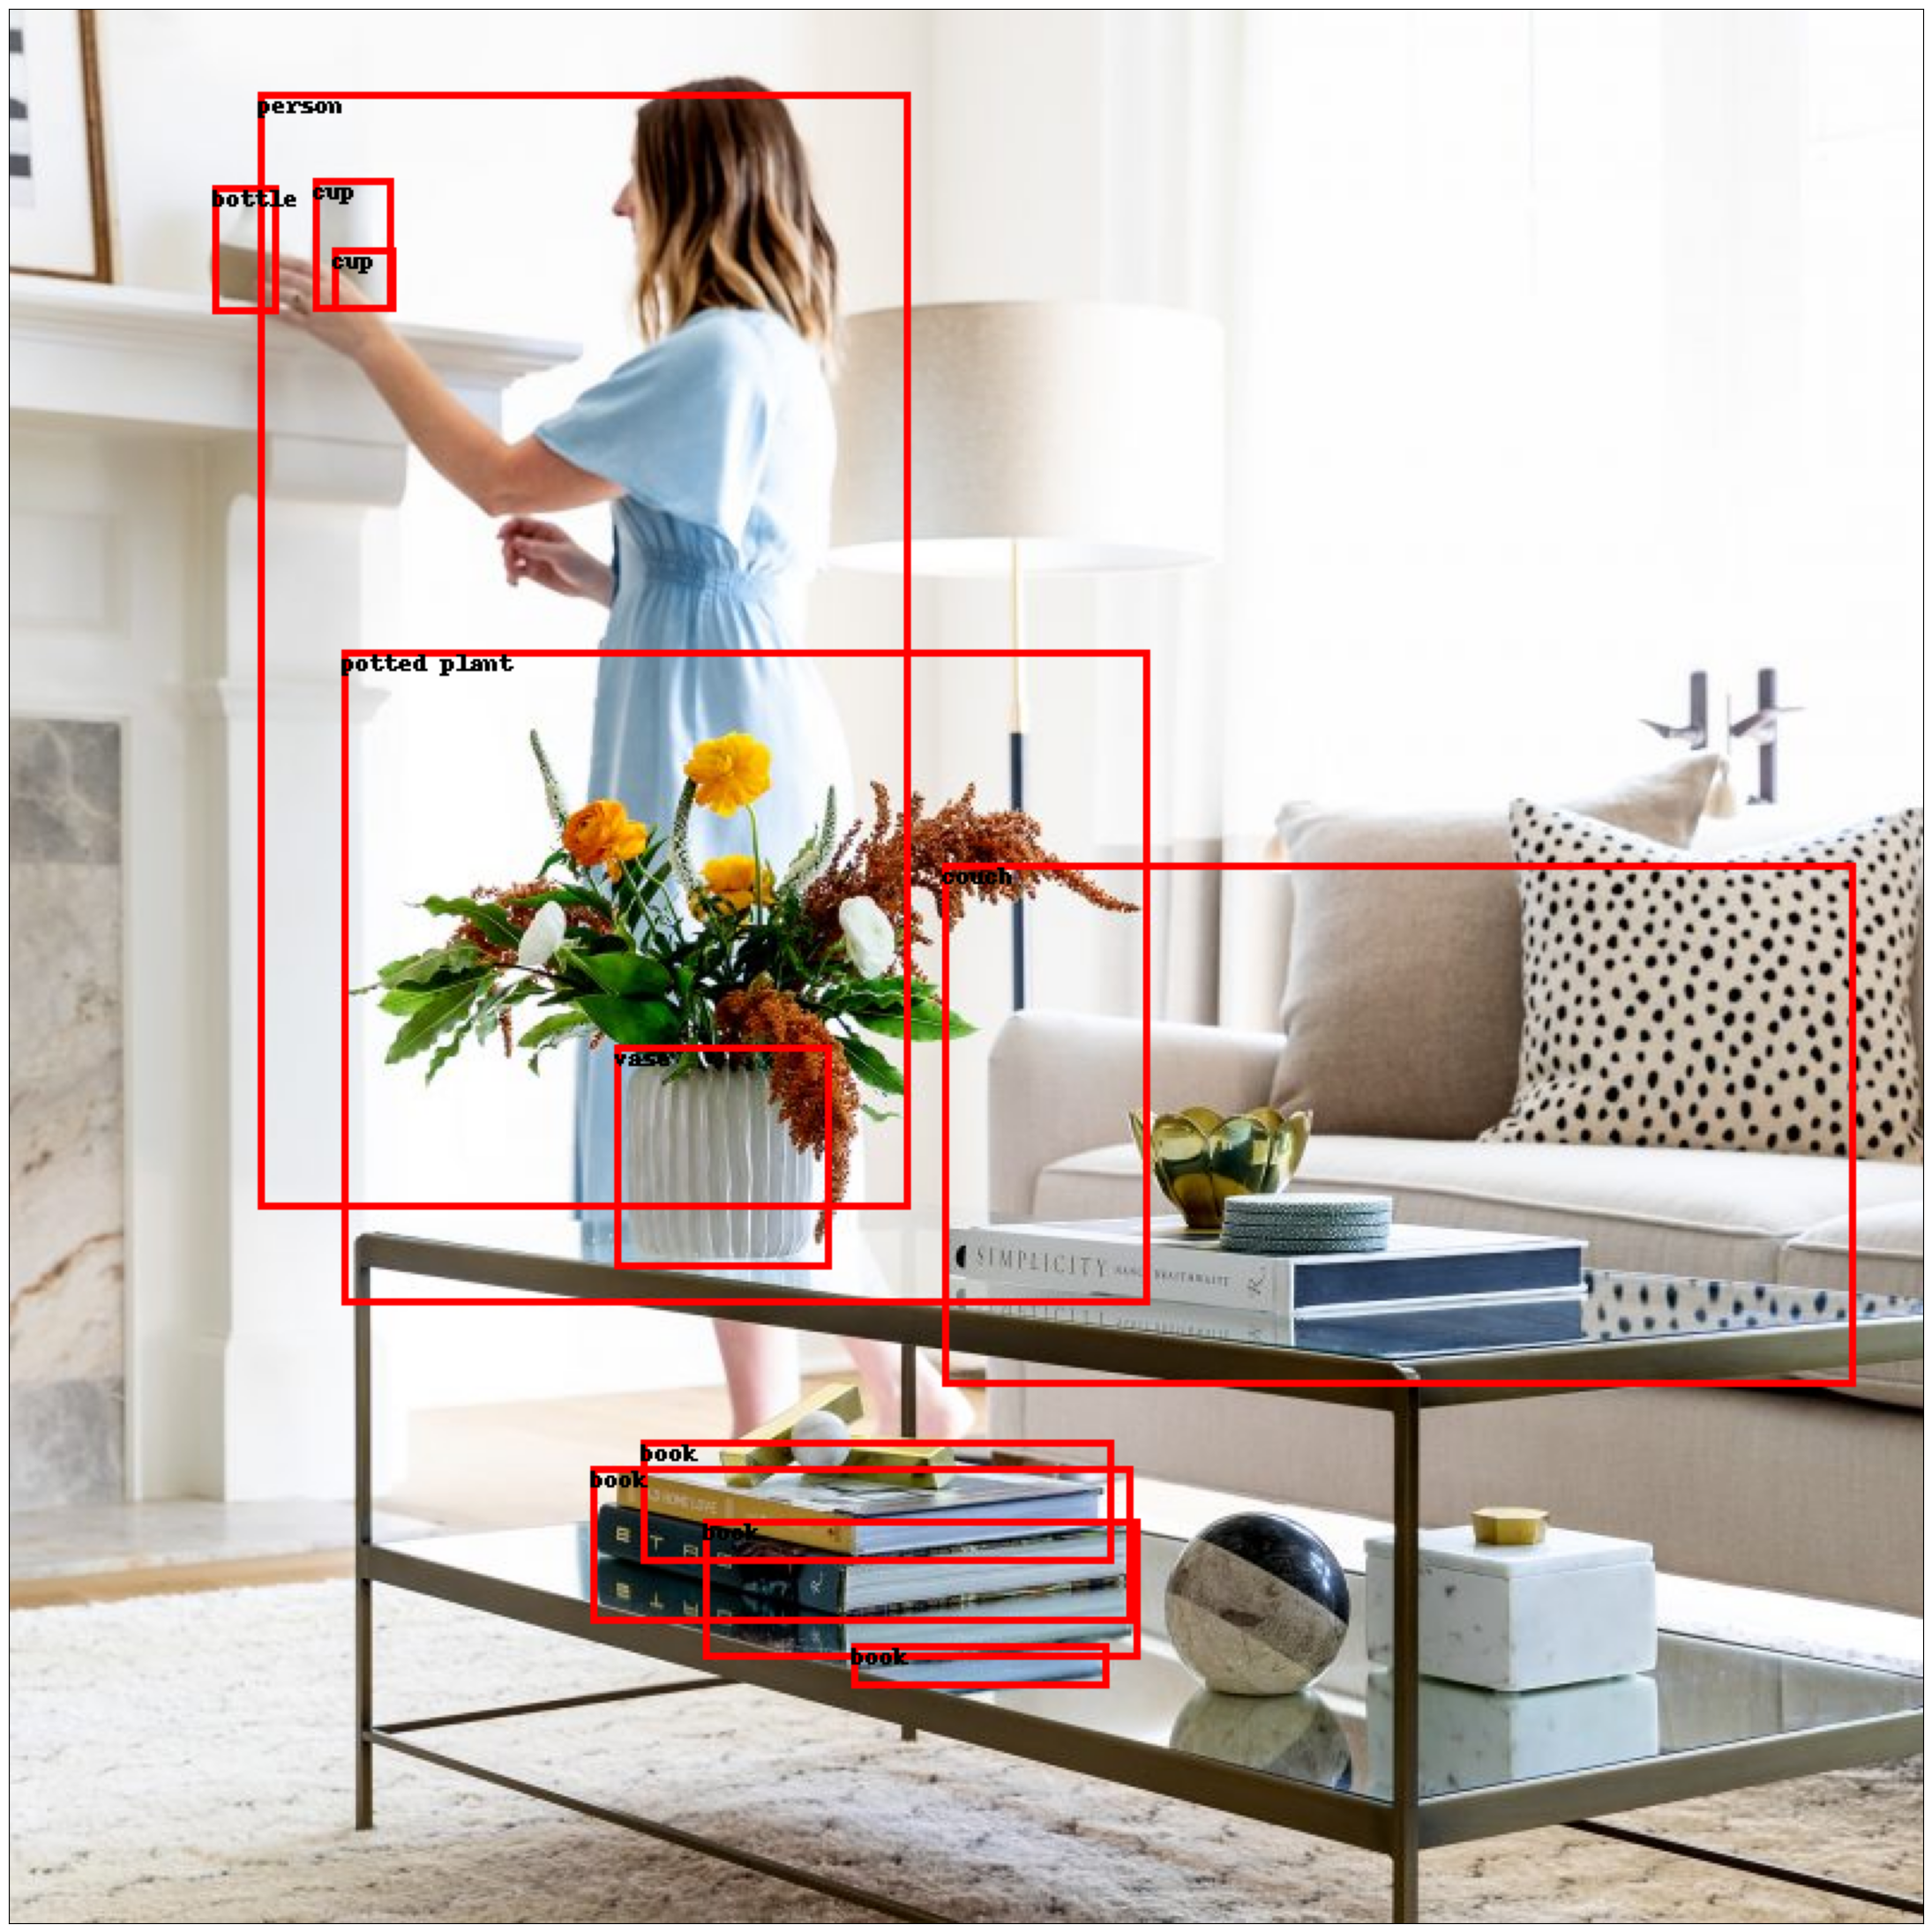

fasterrcnn_resnet50_fpn :	Testing image no. (2)...


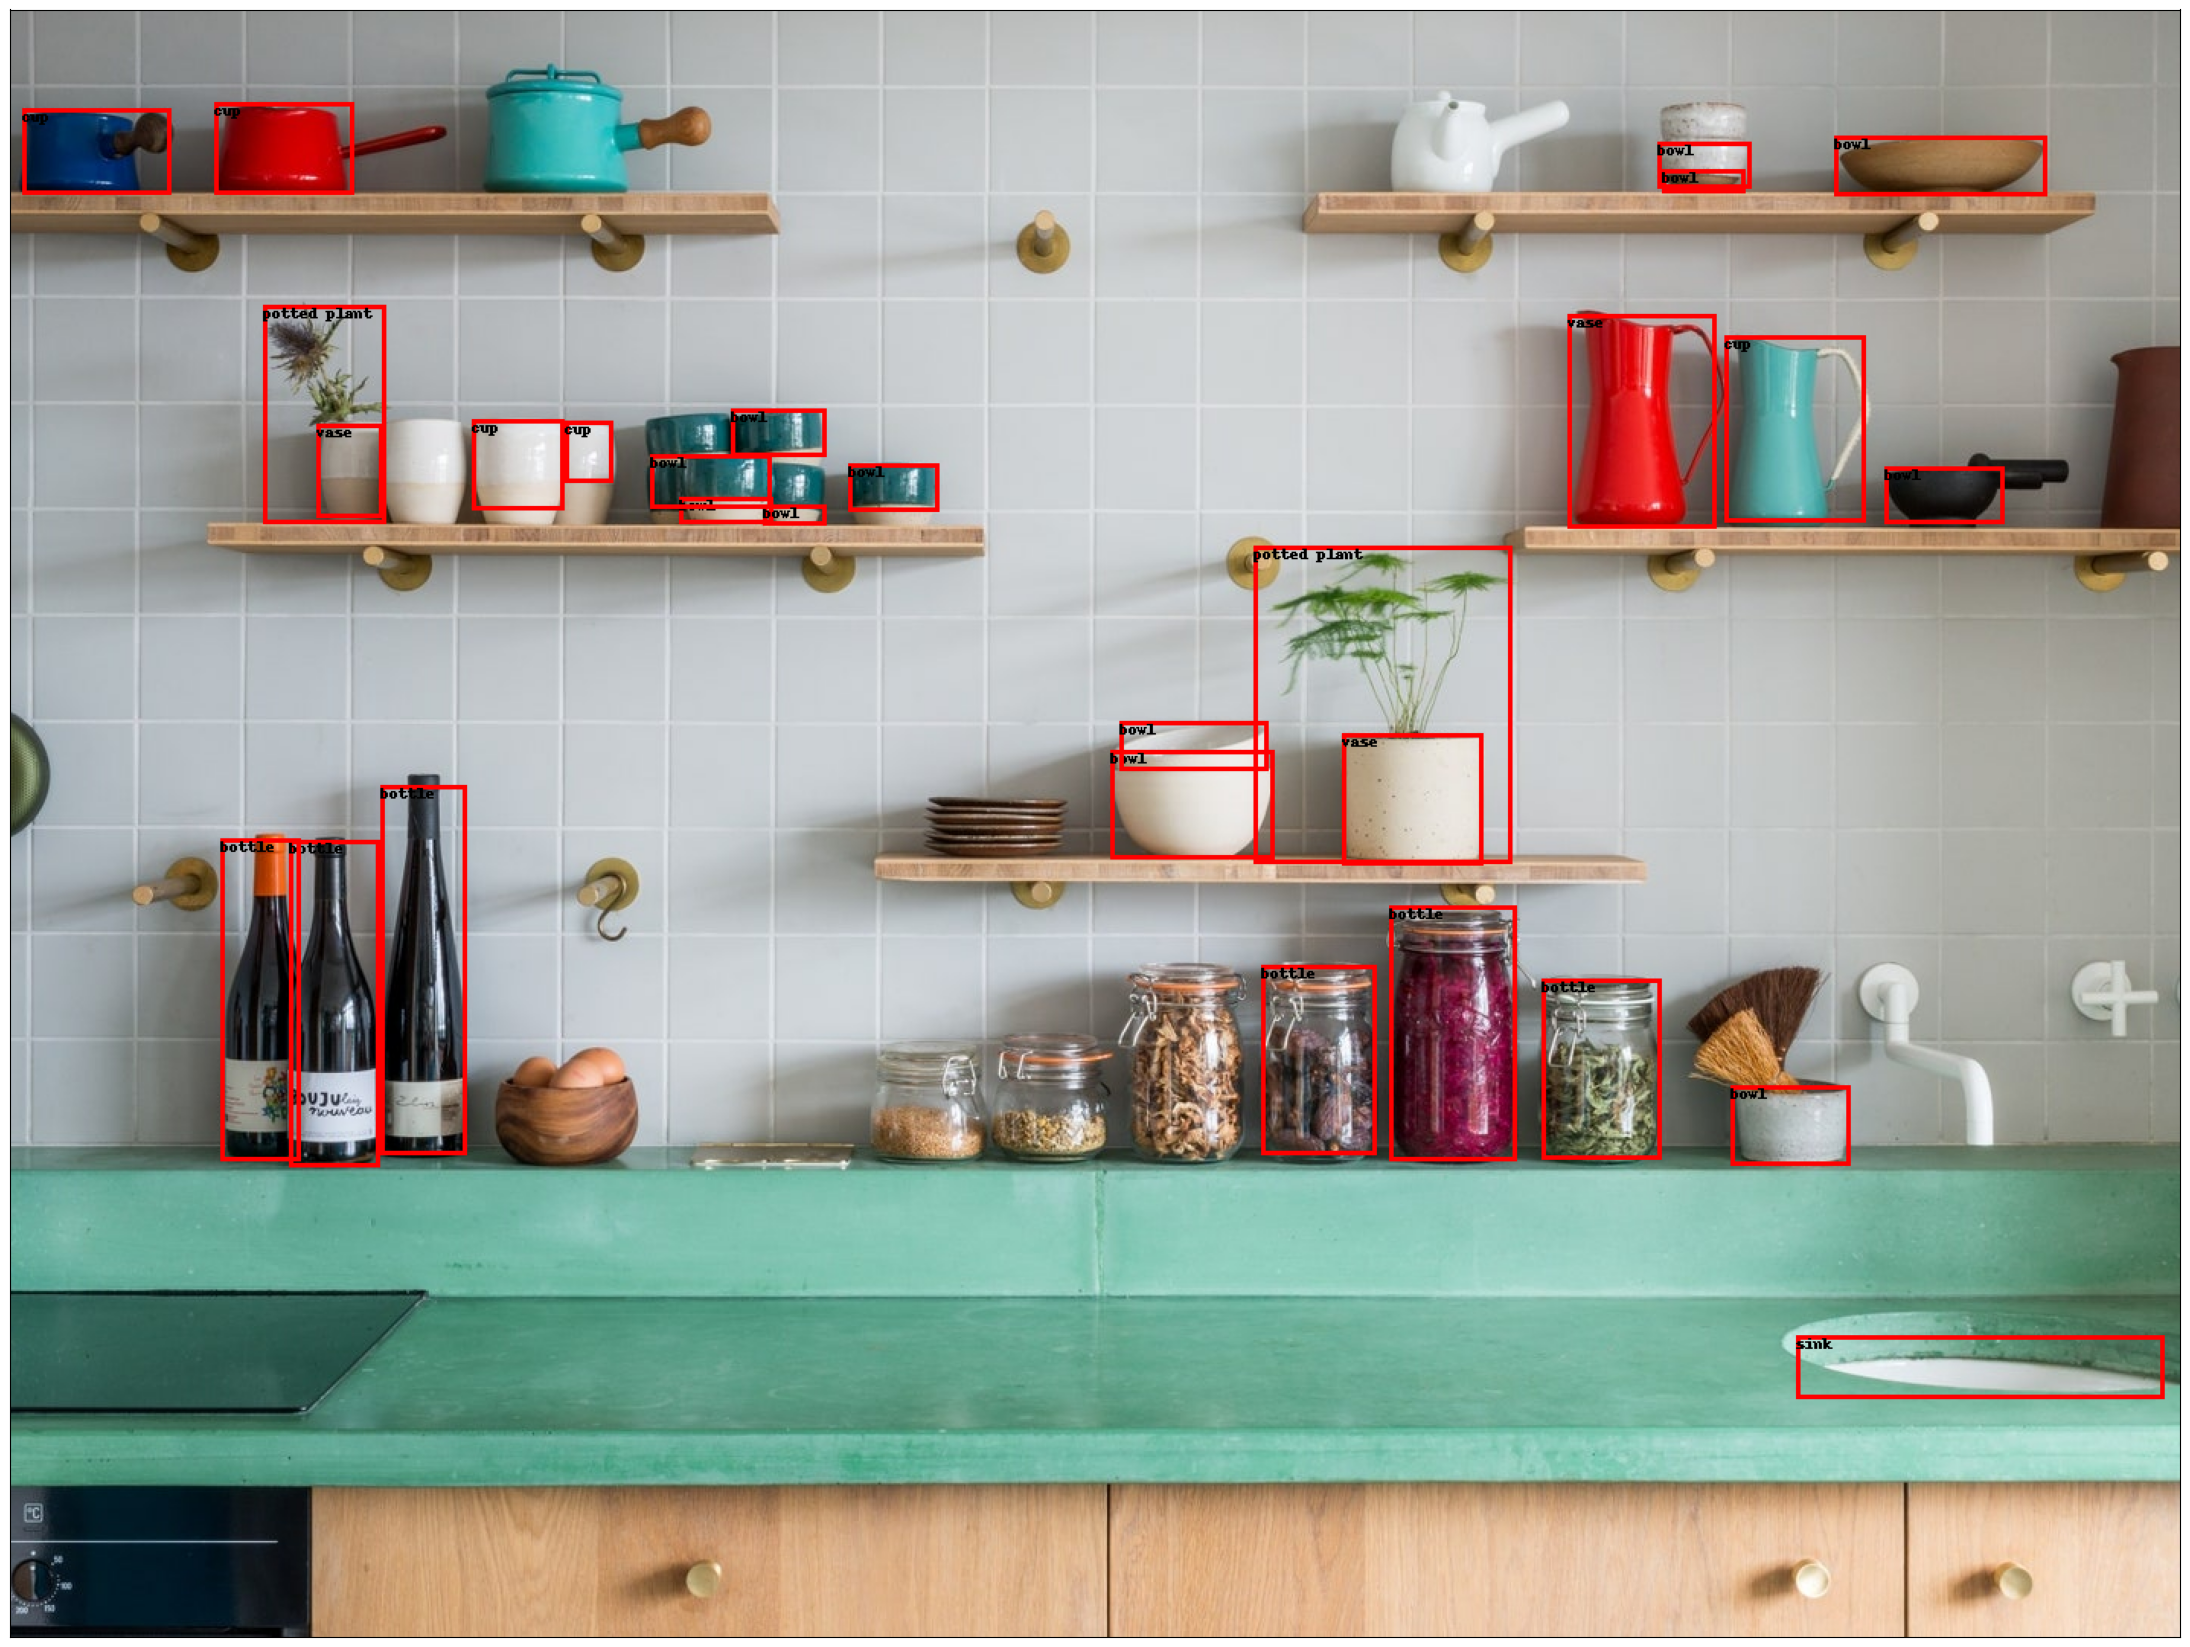

In [ ]:
# use show_detections to display results for models that are **75% confident**
for i in range(len(files)):
    print(model0.name, f":\tTesting image no. ({i + 1})...")
    show_detections(files[i], model0, i, 0.6)


# **Export for Unity**

In [ ]:
# Get the bounding box, the label, export as a JSON maybe for Unity upload...

# 1 IDEA:
#   to keep relative positions of detected objects, could employ use of
#   math distance formulas between boundings boxes maybe